### **Variable Description**
The dataset contains the following variables:

• **Comment ID** : A unique identifier for each comment.

• **Score** : The score or popularity of the comment within the
platform.

• **Comment Text**: The textual content of the comment.

• **Subreddit**: The subreddit (if available) to which the comment belongs.

• **Created Time**: The timestamp indicating when the comment was posted.


### Importing Required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import re
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA

In [3]:
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Data Exploration

In [48]:
#reading data from csv file
ipw_data = pd.read_csv("/content/drive/MyDrive/Mentorness/Copy of pls_isl_conflict_comments.csv",encoding='latin1',parse_dates=True, on_bad_lines='skip')


<ipython-input-48-3e22688ec9e8>:2: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  ipw_data = pd.read_csv("/content/drive/MyDrive/Mentorness/Copy of pls_isl_conflict_comments.csv",encoding='latin1',parse_dates=True, on_bad_lines='skip')


In [49]:
ipw_data.head()

,comment_id,score,self_text,subreddit,created_time
0,k5480sx,1,Exactly! I can remember the humanitarian aid s...,worldnews,16-10-2023 19:39
1,k547q14,1,*We are the only part of the World that has Fr...,Palestine,16-10-2023 19:36
2,k547elf,1,"I dont make Israeli strategy, nor am I Israel...",worldnews,16-10-2023 19:34
3,k54742r,1,These people didn't vote Hamas in or something...,worldnews,16-10-2023 19:32
4,k5473zi,1,We don't care what you do. We just want to liv...,worldnews,16-10-2023 19:32


In [50]:
ipw_data.tail()

,comment_id,score,self_text,subreddit,created_time
1359048,k3sdwfc,42,US. This is bullshit,Palestine,07-10-2023 05:20
1359049,k3sdixt,1,I am in the United States and it has the dotte...,Palestine,07-10-2023 05:17
1359050,k3sccp2,54,In which country are you?\nSometimes maps adap...,Palestine,07-10-2023 05:08
1359051,k3ritvj,116,You can't give up on something you only preten...,worldnews,07-10-2023 01:46
1359052,k3riboh,30,&gt; The head of Islamic Jihad denounced Arab ...,worldnews,07-10-2023 01:42


In [51]:
ipw_data.sample(5)

,comment_id,score,self_text,subreddit,created_time
875402,=,NaN,NaN,NaN,NaN
1325206,k435c60,6,"""Play Stupid Games, Win Stupid Prizes"" \n\nOpi...",AskMiddleEast,09-10-2023 09:26
465548,k4rnivo,1,Exactly=O<û=,NaN,NaN
1119202,k475jfr,5,We really need Luffy to liberate Palestine jus...,NaN,NaN
167870,55,NaN,NaN,NaN,NaN


In [52]:
# getting information about the dataset
ipw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359053 entries, 0 to 1359052
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   comment_id    1359028 non-null  object
 1   score         730353 non-null   object
 2   self_text     730294 non-null   object
 3   subreddit     254711 non-null   object
 4   created_time  189327 non-null   object
dtypes: object(5)
memory usage: 51.8+ MB


**Observations**
                  
  1. "comment_id" contains some invalid values. It has double the values compared to "self_text". It should start with 'k' and the length should be 7.

  2. "score" contains NaN values and data type is not integer.

  3. "self_text" contains NaN values.

  4. "subreddit" contains NaN values.

  5. "created_time" contains NaN values and is not of datetime datatype.

# Data Preprocessing

In [53]:
#removing null values from the dataset
ipw_data.dropna(inplace=True)

In [54]:
#checking the dataset again
ipw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189327 entries, 0 to 1359052
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_id    189327 non-null  object
 1   score         189327 non-null  object
 2   self_text     189327 non-null  object
 3   subreddit     189327 non-null  object
 4   created_time  189327 non-null  object
dtypes: object(5)
memory usage: 8.7+ MB


**Observations**

After removing null values all the columns have the same number of values.

In [55]:
# copying data to preserve the dataset
df1=ipw_data.copy()

In [56]:
#converting 'score' from object data type to integer
df1['score'] = pd.to_numeric(df['score'], errors='coerce')
df1.dropna(inplace=True)
df1['score'] = df1['score'].astype(int)

In [57]:
#checking the dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189323 entries, 0 to 1359052
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_id    189323 non-null  object
 1   score         189323 non-null  int64 
 2   self_text     189323 non-null  object
 3   subreddit     189323 non-null  object
 4   created_time  189323 non-null  object
dtypes: int64(1), object(4)
memory usage: 8.7+ MB


**Observation**

4 values were removed after casting values of 'score' to integer.

In [58]:
# converting 'created_time' datatype from object to datetime
df1['created_time'] = pd.to_datetime(df1['created_time'], errors='coerce')

In [59]:
#checking the dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189323 entries, 0 to 1359052
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   comment_id    189323 non-null  object        
 1   score         189323 non-null  int64         
 2   self_text     189323 non-null  object        
 3   subreddit     189323 non-null  object        
 4   created_time  189321 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 8.7+ MB


In [60]:
#removing null values
df1.dropna(inplace=True)

In [61]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189321 entries, 0 to 1359052
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   comment_id    189321 non-null  object        
 1   score         189321 non-null  int64         
 2   self_text     189321 non-null  object        
 3   subreddit     189321 non-null  object        
 4   created_time  189321 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 8.7+ MB


**Observation**

2 values were removed after converting 'created_time' to datetime datatype and removing null values.

In [62]:
#checking duplicate values
df1.duplicated().sum()

0

In [63]:
#checking sample of "comment_id"
df1.comment_id.sample(6)

25021      k4xzvgt
1110040    k48icl1
1338007    k3znj5o
17560      k4ze5xo
1057157    k4n5jcx
1098664    k4bckai
Name: comment_id, dtype: object

In [64]:
#'comment_id' must start with 'k' and should be of length 7
df1 = df1[df1['comment_id'].str.startswith('k') & (df1['comment_id'].str.len() == 7)]

In [65]:
#checking the dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189321 entries, 0 to 1359052
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   comment_id    189321 non-null  object        
 1   score         189321 non-null  int64         
 2   self_text     189321 non-null  object        
 3   subreddit     189321 non-null  object        
 4   created_time  189321 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 8.7+ MB


**Observation**

After data preprocessing the number of records left are 189321.

In [67]:
#resetting index
df1=df1.reset_index()

In [68]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189321 entries, 0 to 189320
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   index         189321 non-null  int64         
 1   comment_id    189321 non-null  object        
 2   score         189321 non-null  int64         
 3   self_text     189321 non-null  object        
 4   subreddit     189321 non-null  object        
 5   created_time  189321 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 8.7+ MB


# Exploratory Data Analysis (EDA)

In [69]:
# counting the total number of subreddits in this dataset
print(f" The Total Number of Subreddits present in this Dataset are {df1['subreddit'].nunique()}")

 The Total Number of Subreddits present in this Dataset are 14


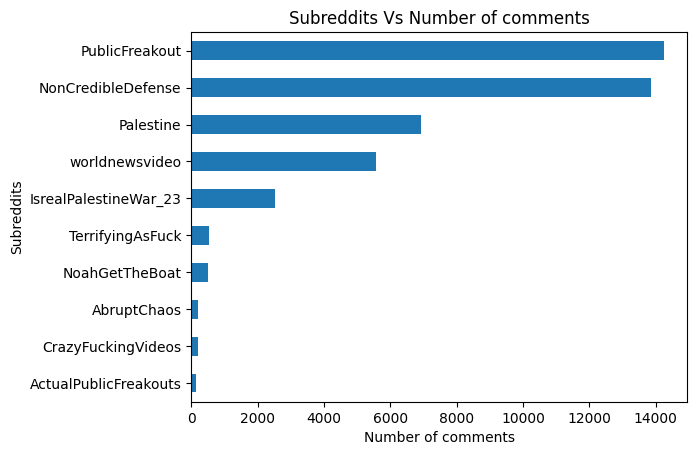

In [70]:
# visualizing the Top10 subreddits with most comments
df1['subreddit'].value_counts().sort_values(ascending=True).head(10).plot(kind="barh")
plt.xlabel('Number of comments')
plt.ylabel('Subreddits')
plt.title('Subreddits Vs Number of comments')
plt.show()

In [71]:
#getting statistical information about numeric and non numeric values
df1.describe(include=['object','datetime','int'])

<ipython-input-71-be78ed5b62a9>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1.describe(include=['object','datetime','int'])


,index,comment_id,score,self_text,subreddit,created_time
count,1.893210e+05,189321,189321.000000,189321,189321,189321
unique,NaN,189321,NaN,186026,14,13562
top,NaN,k5480sx,NaN,your comment has been removed for having a low...,IsraelPalestine,2023-10-14 21:24:00
freq,NaN,1,NaN,104,52533,68
first,NaN,NaN,NaN,NaN,NaN,2023-07-10 01:42:00
last,NaN,NaN,NaN,NaN,NaN,2023-12-10 23:59:00
mean,8.250315e+05,NaN,28.613191,NaN,NaN,NaN
std,4.956113e+05,NaN,180.086547,NaN,NaN,NaN
min,0.000000e+00,NaN,-934.000000,NaN,NaN,NaN
25%,4.021730e+05,NaN,1.000000,NaN,NaN,NaN


In [72]:
# Top 10 most upvotes given to comments
df1.score.sort_values(ascending=False).head(10)

108189    16463
94167     14619
187726    10421
181981    10090
67638      8708
123583     8493
36659      8257
108140     8225
93288      8220
147435     7824
Name: score, dtype: int64

In [73]:
# Top 10 Most Upvoted Comments
most_upvoted_comments=df1.nlargest(10,'score')[['comment_id','score','self_text']]

In [74]:
most_upvoted_comments

,comment_id,score,self_text
108189,k4flv7n,16463,Thats pretty damning for Netanyahu and Israel...
94167,k4jondz,14619,Israel said there would be no humanitarian bre...
187726,k3u3l41,10421,This weekend is going to be very ugly in the M...
181981,k3vpfsl,10090,This is not going to end well. shit
67638,k4pjh8d,8708,"&gt;""These Palestinian people, they're victims..."
123583,k4b2bua,8493,It is shockingly easy to go through life witho...
36659,k4v0oiu,8257,Giving South Park were sorry energy
108140,k4fmji6,8225,It's such a disaster that I don't see how Neta...
93288,k4jy3t9,8220,TIL Reuters has a reddit account!
147435,k453295,7824,"""Egypts Intelligence Minister General Abbas K..."


In [75]:
#most upvoted comment
most_upvoted_comments['self_text'][108189]

'That\x19s pretty damning for Netanyahu and Israeli intelligence no?'

In [76]:
# Top 10 least upvotes given to comments
df1.score.sort_values().head(10)

189004   -934
65198    -763
188974   -548
183783   -371
63725    -351
82137    -349
184072   -346
155223   -334
183432   -305
151170   -301
Name: score, dtype: int64

In [77]:
# Top 10 Least Upvoted Comments
least_upvoted_comments=df1.nsmallest(10,'score')[['comment_id','score','self_text']]

In [78]:
least_upvoted_comments

,comment_id,score,self_text
189004,k3tmbcz,-934,too bad its pretty much pointless when they fi...
65198,k4q56j0,-763,"For once, an actual proven military target."
188974,k3tmvkm,-548,the defensive approach taken by using iron dom...
183783,k3v6bq0,-371,"how gentle, smh"
63725,k4qg23j,-351,They're doing it because western pressure and ...
82137,k4myoqn,-349,"No food, water, medicine, electricity, and the..."
184072,k3v4mdu,-346,How can they claim to be any better than the o...
155223,k438bf4,-334,Every single missile strike you guys say the s...
183432,k3v96re,-305,Probably since the 1920s when Britain colonize...
151170,k447037,-301,Whoever filmed this seems like a bit of a ber...


In [80]:
#least upvoted comment
least_upvoted_comments['self_text'][189004]

'too bad its pretty much pointless when they fire thousands of rockets.'

In [81]:
df1.tail()

,index,comment_id,score,self_text,subreddit,created_time
189316,1359048,k3sdwfc,42,US. This is bullshit,Palestine,2023-07-10 05:20:00
189317,1359049,k3sdixt,1,I am in the United States and it has the dotte...,Palestine,2023-07-10 05:17:00
189318,1359050,k3sccp2,54,In which country are you?\nSometimes maps adap...,Palestine,2023-07-10 05:08:00
189319,1359051,k3ritvj,116,You can't give up on something you only preten...,worldnews,2023-07-10 01:46:00
189320,1359052,k3riboh,30,&gt; The head of Islamic Jihad denounced Arab ...,worldnews,2023-07-10 01:42:00


In [82]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189321 entries, 0 to 189320
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   index         189321 non-null  int64         
 1   comment_id    189321 non-null  object        
 2   score         189321 non-null  int64         
 3   self_text     189321 non-null  object        
 4   subreddit     189321 non-null  object        
 5   created_time  189321 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 8.7+ MB


## Cleaning comments in 'sub_text'

In [83]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Remove special characters and lowercase the text
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Lemmatization and removing stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join the tokens back into a sentence
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Example usage on 'self_text' column of your DataFrame
df1['clean_text'] = df1['self_text'].apply(clean_text)

<ipython-input-83-d1a8a38cb010>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [84]:
# getting information about the dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189321 entries, 0 to 189320
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   index         189321 non-null  int64         
 1   comment_id    189321 non-null  object        
 2   score         189321 non-null  int64         
 3   self_text     189321 non-null  object        
 4   subreddit     189321 non-null  object        
 5   created_time  189321 non-null  datetime64[ns]
 6   clean_text    189321 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 10.1+ MB


In [85]:
#Observing the cleaned text
df1.clean_text.head()

0    exactly remember humanitarian aid streaming st...
1    part world freedom speech person exercise free...
2    dont make israeli strategy israeli jewish dont...
3    people didnt vote hamas something cant exactly...
4    dont care want live world literally impossible...
Name: clean_text, dtype: object

In [86]:
df1.tail()

,index,comment_id,score,self_text,subreddit,created_time,clean_text
189316,1359048,k3sdwfc,42,US. This is bullshit,Palestine,2023-07-10 05:20:00,u bullshit
189317,1359049,k3sdixt,1,I am in the United States and it has the dotte...,Palestine,2023-07-10 05:17:00,united state dotted west bank gaza strip altho...
189318,1359050,k3sccp2,54,In which country are you?\nSometimes maps adap...,Palestine,2023-07-10 05:08:00,country sometimes map adapt country view matte...
189319,1359051,k3ritvj,116,You can't give up on something you only preten...,worldnews,2023-07-10 01:46:00,cant give something pretended support cynical ...
189320,1359052,k3riboh,30,&gt; The head of Islamic Jihad denounced Arab ...,worldnews,2023-07-10 01:42:00,head islamic jihad denounced arab attempt norm...


### Sentiment Analysis Using VADER

In [87]:
# Initialize the Sentiment Intensity Analyzer
analyzer = SentimentIntensityAnalyzer()

# Declare variables for scores
scores = {
    "Compound": [],
    "Positive": [],
    "Negative": [],
    "Neutral": []
}

# saving scores for each comment using VADER
for comment in df1['clean_text']:
    compound = analyzer.polarity_scores(comment)["compound"]
    pos = analyzer.polarity_scores(comment)["pos"]
    neu = analyzer.polarity_scores(comment)["neu"]
    neg = analyzer.polarity_scores(comment)["neg"]

    scores["Compound"].append(compound)
    scores["Positive"].append(pos)
    scores["Negative"].append(neg)
    scores["Neutral"].append(neu)
# Create a new DataFrame for sentiment scores
sentiments_score = pd.DataFrame(scores)

# Join the sentiment scores DataFrame with the original DataFrame
df1 = pd.concat([df1, sentiments_score], axis=1)

In [88]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189321 entries, 0 to 189320
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   index         189321 non-null  int64         
 1   comment_id    189321 non-null  object        
 2   score         189321 non-null  int64         
 3   self_text     189321 non-null  object        
 4   subreddit     189321 non-null  object        
 5   created_time  189321 non-null  datetime64[ns]
 6   clean_text    189321 non-null  object        
 7   Compound      189321 non-null  float64       
 8   Positive      189321 non-null  float64       
 9   Negative      189321 non-null  float64       
 10  Neutral       189321 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 15.9+ MB


In [89]:
df1.head()

,index,comment_id,score,self_text,subreddit,created_time,clean_text,Compound,Positive,Negative,Neutral
0,0,k5480sx,1,Exactly! I can remember the humanitarian aid s...,worldnews,2023-10-16 19:39:00,exactly remember humanitarian aid streaming st...,0.3612,0.082,0.000,0.918
1,1,k547q14,1,*We are the only part of the World that has Fr...,Palestine,2023-10-16 19:36:00,part world freedom speech person exercise free...,0.8074,0.507,0.214,0.279
2,2,k547elf,1,"I dont make Israeli strategy, nor am I Israel...",worldnews,2023-10-16 19:34:00,dont make israeli strategy israeli jewish dont...,0.7304,0.257,0.069,0.674
3,3,k54742r,1,These people didn't vote Hamas in or something...,worldnews,2023-10-16 19:32:00,people didnt vote hamas something cant exactly...,-0.5627,0.062,0.125,0.813
4,4,k5473zi,1,We don't care what you do. We just want to liv...,worldnews,2023-10-16 19:32:00,dont care want live world literally impossible...,-0.9883,0.000,0.700,0.300


**Define conditions for sentiment categories based on 'Compound' scores**

If Compound score is <= -0.5, classify as 'Negative'

If Compound score is > -0.5 and < 0.5, classify as 'Neutral'

If Compound score is >= 0.5, classify as 'Positive'

In [90]:
df1.tail()

,index,comment_id,score,self_text,subreddit,created_time,clean_text,Compound,Positive,Negative,Neutral
189316,1359048,k3sdwfc,42,US. This is bullshit,Palestine,2023-07-10 05:20:00,u bullshit,-0.5859,0.000,1.000,0.000
189317,1359049,k3sdixt,1,I am in the United States and it has the dotte...,Palestine,2023-07-10 05:17:00,united state dotted west bank gaza strip altho...,0.4215,0.219,0.000,0.781
189318,1359050,k3sccp2,54,In which country are you?\nSometimes maps adap...,Palestine,2023-07-10 05:08:00,country sometimes map adapt country view matte...,0.0258,0.099,0.000,0.901
189319,1359051,k3ritvj,116,You can't give up on something you only preten...,worldnews,2023-07-10 01:46:00,cant give something pretended support cynical ...,0.0258,0.262,0.252,0.485
189320,1359052,k3riboh,30,&gt; The head of Islamic Jihad denounced Arab ...,worldnews,2023-07-10 01:42:00,head islamic jihad denounced arab attempt norm...,-0.8225,0.060,0.119,0.822


In [91]:
# Define a function to categorize values based on your conditions
def categorize_sentiment(compound_value):
    if compound_value >= 0.5:
        return 'Positive'
    elif compound_value <= -0.5:
        return 'Negative'
    else:
        return 'Neutral'

# Use the apply function to create a new column 'Sentiment' based on 'compound'
df1['Sentiment'] = df1['Compound'].apply(categorize_sentiment)

In [92]:
df1.tail()

,index,comment_id,score,self_text,subreddit,created_time,clean_text,Compound,Positive,Negative,Neutral,Sentiment
189316,1359048,k3sdwfc,42,US. This is bullshit,Palestine,2023-07-10 05:20:00,u bullshit,-0.5859,0.000,1.000,0.000,Negative
189317,1359049,k3sdixt,1,I am in the United States and it has the dotte...,Palestine,2023-07-10 05:17:00,united state dotted west bank gaza strip altho...,0.4215,0.219,0.000,0.781,Neutral
189318,1359050,k3sccp2,54,In which country are you?\nSometimes maps adap...,Palestine,2023-07-10 05:08:00,country sometimes map adapt country view matte...,0.0258,0.099,0.000,0.901,Neutral
189319,1359051,k3ritvj,116,You can't give up on something you only preten...,worldnews,2023-07-10 01:46:00,cant give something pretended support cynical ...,0.0258,0.262,0.252,0.485,Neutral
189320,1359052,k3riboh,30,&gt; The head of Islamic Jihad denounced Arab ...,worldnews,2023-07-10 01:42:00,head islamic jihad denounced arab attempt norm...,-0.8225,0.060,0.119,0.822,Negative


In [95]:
df1.head()

,index,comment_id,score,self_text,subreddit,created_time,clean_text,Compound,Positive,Negative,Neutral,Sentiment
0,0,k5480sx,1,Exactly! I can remember the humanitarian aid s...,worldnews,2023-10-16 19:39:00,exactly remember humanitarian aid streaming st...,0.3612,0.082,0.000,0.918,Neutral
1,1,k547q14,1,*We are the only part of the World that has Fr...,Palestine,2023-10-16 19:36:00,part world freedom speech person exercise free...,0.8074,0.507,0.214,0.279,Positive
2,2,k547elf,1,"I dont make Israeli strategy, nor am I Israel...",worldnews,2023-10-16 19:34:00,dont make israeli strategy israeli jewish dont...,0.7304,0.257,0.069,0.674,Positive
3,3,k54742r,1,These people didn't vote Hamas in or something...,worldnews,2023-10-16 19:32:00,people didnt vote hamas something cant exactly...,-0.5627,0.062,0.125,0.813,Negative
4,4,k5473zi,1,We don't care what you do. We just want to liv...,worldnews,2023-10-16 19:32:00,dont care want live world literally impossible...,-0.9883,0.000,0.700,0.300,Negative


In [96]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189321 entries, 0 to 189320
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   index         189321 non-null  int64         
 1   comment_id    189321 non-null  object        
 2   score         189321 non-null  int64         
 3   self_text     189321 non-null  object        
 4   subreddit     189321 non-null  object        
 5   created_time  189321 non-null  datetime64[ns]
 6   clean_text    189321 non-null  object        
 7   Compound      189321 non-null  float64       
 8   Positive      189321 non-null  float64       
 9   Negative      189321 non-null  float64       
 10  Neutral       189321 non-null  float64       
 11  Sentiment     189321 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 17.3+ MB


In [97]:
df1.shape

(189321, 12)

In [99]:
# Group the DataFrame by 'Sentiment' and count the occurrences of each category
category_counts = df1.groupby(['Sentiment'])['Sentiment'].count()

# Create a DataFrame with counts and rename the column to 'Counts'
counts_df = pd.DataFrame(category_counts).rename(columns={"Sentiment": "Counts"})

# Calculate the percentage for each category and add it as a new column 'Percentage'
counts_df['Percentage'] = (counts_df['Counts'] / counts_df['Counts'].sum()) * 100

# Print or return the summary DataFrame
print(counts_df)

           Counts  Percentage
Sentiment                    
Negative    52859   27.920305
Neutral    108438   57.277323
Positive    28024   14.802373


In [100]:
import plotly.express as px

fig= plt.figure(figsize=(8,5))
# Create a Pie Chart using Plotly
fig = px.pie(counts_df, values='Counts', names=counts_df.index,
             labels={'Sentiment': 'Sentiment Category', 'Counts': 'Count'},
             title='Distribution of Sentiment Categories in Comments',
             hole=0.3)

fig.show()

<Figure size 800x500 with 0 Axes>

<ipython-input-101-b37c5de61631>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-101-b37c5de61631>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-101-b37c5de61631>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please a

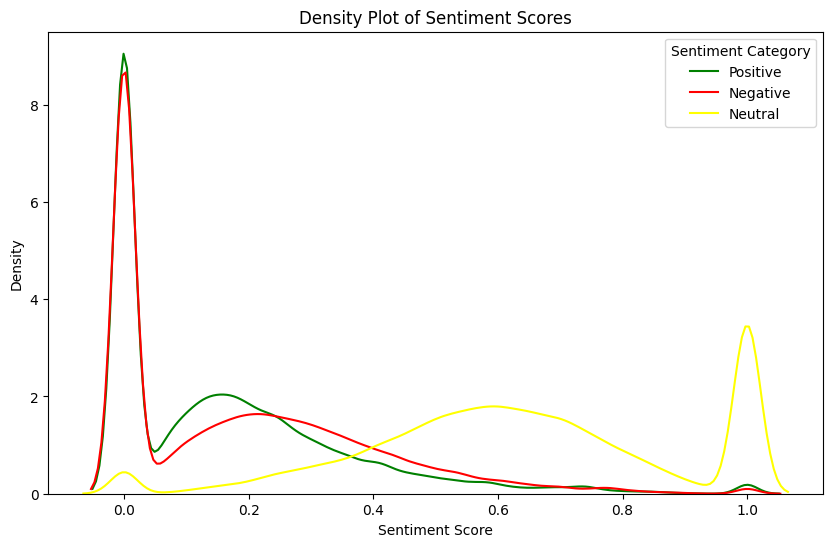

In [101]:
# Define the sentiment categories and corresponding colors
sentiment_categories = ["Positive", "Negative", "Neutral"]
colors = ['green', 'red', 'yellow']

# Set up the plot
plt.figure(figsize=(10, 6))

# Iterate over sentiment categories and plot KDE
for category, color in zip(sentiment_categories, colors):
    sns.distplot(df1[category], hist=False, kde=True,
                 bins=int(180/5), color=color,
                 label=category)

plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores')
plt.legend(title='Sentiment Category')

# Show the plot
plt.show()

<ipython-input-102-e6351f7f4305>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




<Axes: xlabel='Compound', ylabel='Density'>

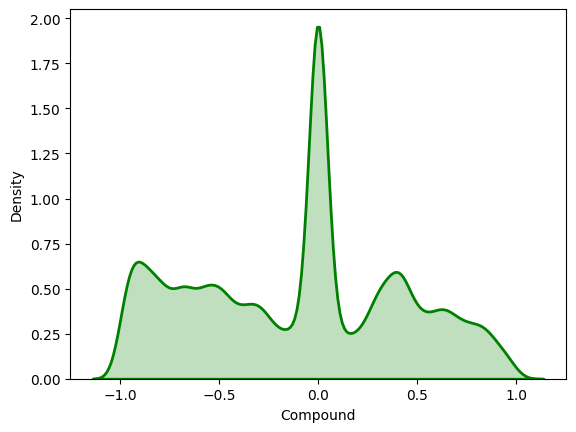

In [102]:
sns.distplot(df1["Compound"], hist=False, kde=True,
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

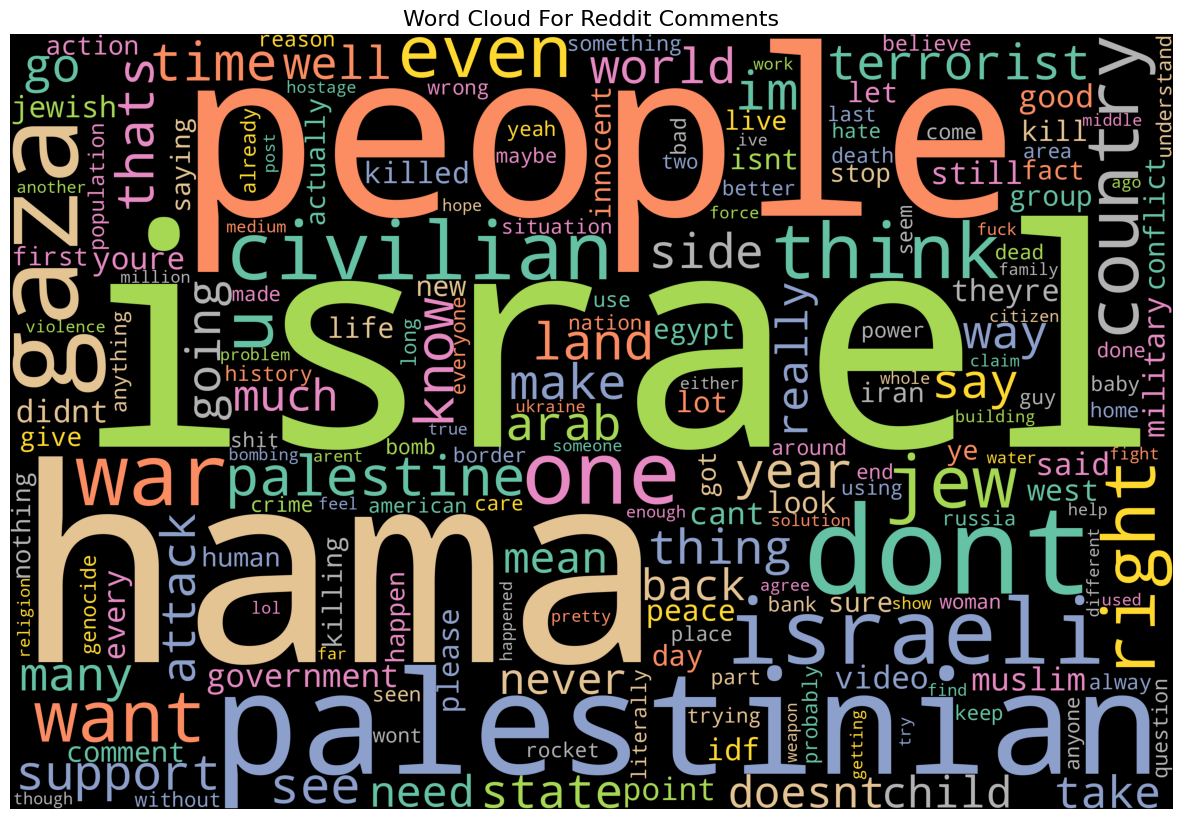

In [109]:
# Concatenate all comments into a single string
text = " ".join(str(comment) for comment in df1.clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(15,15))

plt.title('Word Cloud For Reddit Comments', fontsize=16)

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [104]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189321 entries, 0 to 189320
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   index         189321 non-null  int64         
 1   comment_id    189321 non-null  object        
 2   score         189321 non-null  int64         
 3   self_text     189321 non-null  object        
 4   subreddit     189321 non-null  object        
 5   created_time  189321 non-null  datetime64[ns]
 6   clean_text    189321 non-null  object        
 7   Compound      189321 non-null  float64       
 8   Positive      189321 non-null  float64       
 9   Negative      189321 non-null  float64       
 10  Neutral       189321 non-null  float64       
 11  Sentiment     189321 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 17.3+ MB


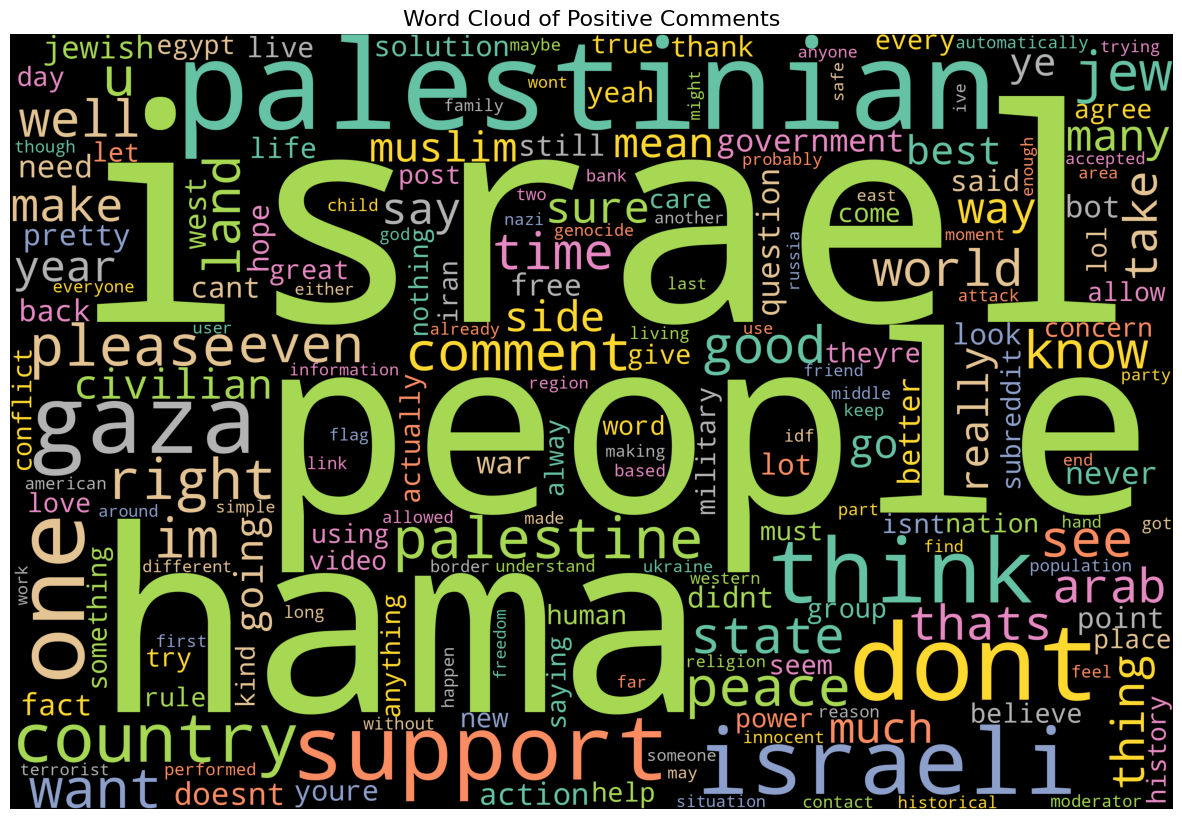

In [110]:
# Concatenate all comments into a single string
text = " ".join(str(comment) for comment in df1[df1['Sentiment']=='Positive'].clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(15,15))
plt.title('Word Cloud of Positive Comments', fontsize=16)
# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

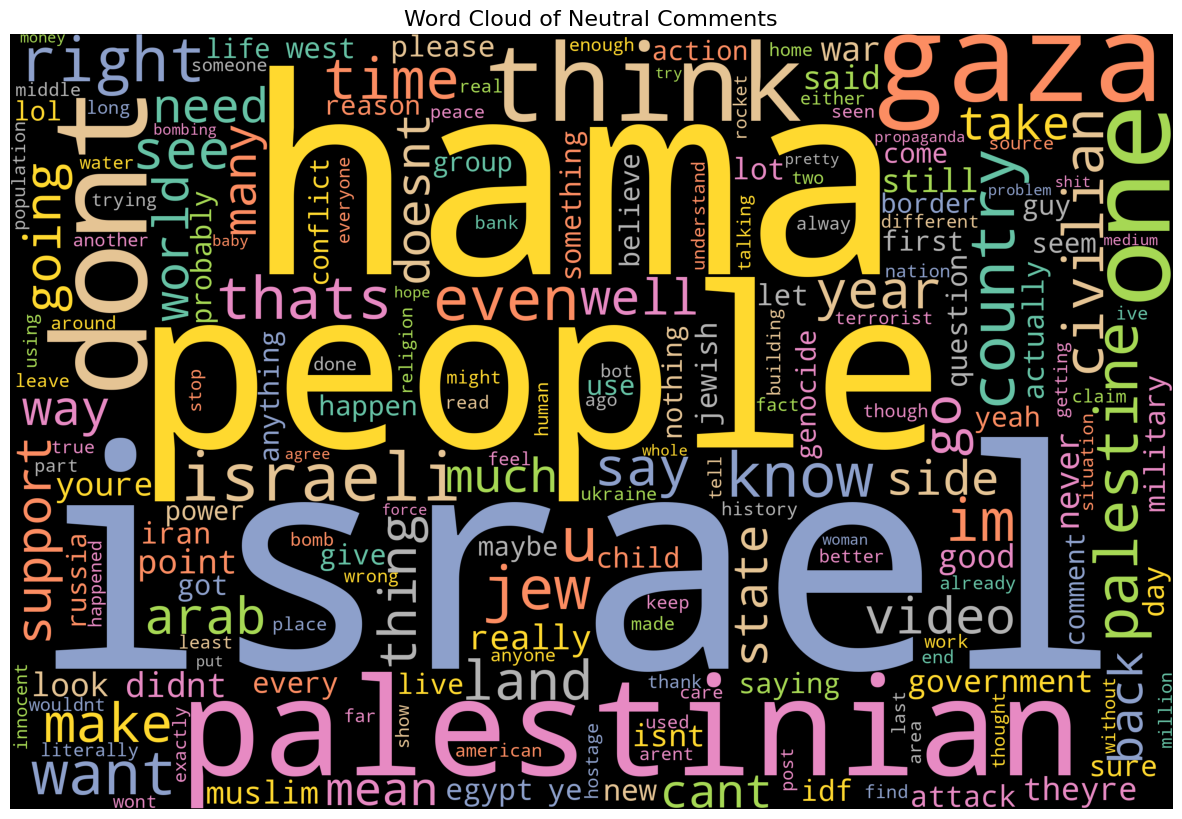

In [111]:
# Concatenate all comments into a single string
text = " ".join(str(comment) for comment in df1[df1['Sentiment']=='Neutral'].clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(15,15))
plt.title('Word Cloud of Neutral Comments', fontsize=16)
# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

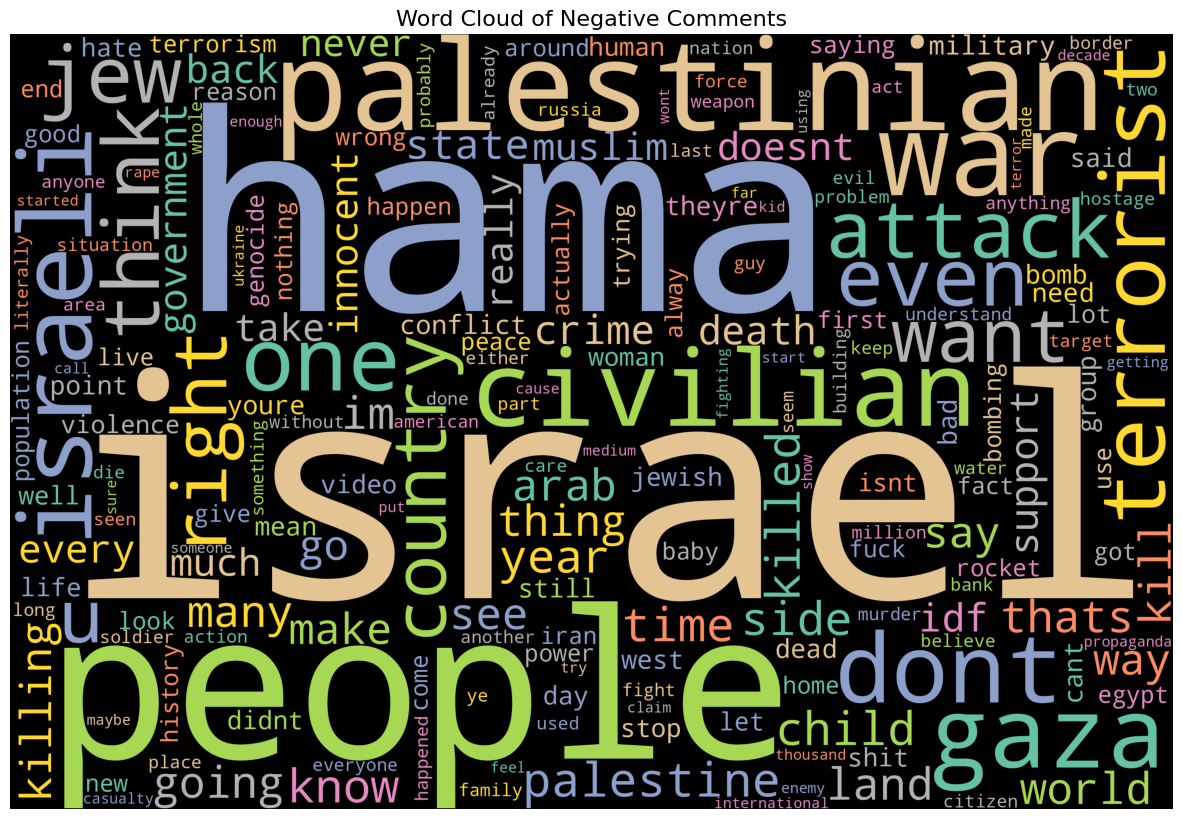

In [112]:
# Concatenate all comments into a single string
text = " ".join(str(comment) for comment in df1[df1['Sentiment']=='Negative'].clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(15,15))
plt.title('Word Cloud of Negative Comments', fontsize=16)

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [108]:
# Assuming 'clean_text' is the column with text data
df1['clean_text'].fillna('', inplace=True)

# Topic Modeling
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df1['clean_text'])

lda_model = LatentDirichletAllocation(n_components=5, random_state=42, n_jobs=-1)
lda_topic_matrix = lda_model.fit_transform(tfidf_matrix)


In [113]:
# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the top words for each topic
n_top_words = 10  # You can adjust this number to display more or fewer words per topic
top_words_per_topic = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_words_per_topic.append(top_words)

# Print the topics and associated words
for topic_idx, top_words in enumerate(top_words_per_topic):
    print(f"Topic #{topic_idx + 1}:")
    print(", ".join(top_words))
    print()

Topic #1:
hamas, israel, like, rocket, yes, building, russia, time, bomb, attack

Topic #2:
people, hamas, child, civilian, video, like, fuck, baby, dont, israel

Topic #3:
israel, hamas, palestinian, gaza, people, war, palestine, israeli, land, jew

Topic #4:
dont, country, muslim, israel, like, people, lol, iran, think, religion

Topic #5:
comment, question, post, bot, like, good, link, thanks, sub, reddit



In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189321 entries, 0 to 189320
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   comment_id    189321 non-null  object        
 1   score         189321 non-null  int64         
 2   self_text     189321 non-null  object        
 3   subreddit     189321 non-null  object        
 4   created_time  189321 non-null  datetime64[ns]
 5   clean_text    189321 non-null  object        
 6   Compound      189321 non-null  float64       
 7   Positive      189321 non-null  float64       
 8   Negative      189321 non-null  float64       
 9   Neutral       189321 non-null  float64       
 10  Sentiment     189321 non-null  object        
 11  group         189321 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 17.3+ MB


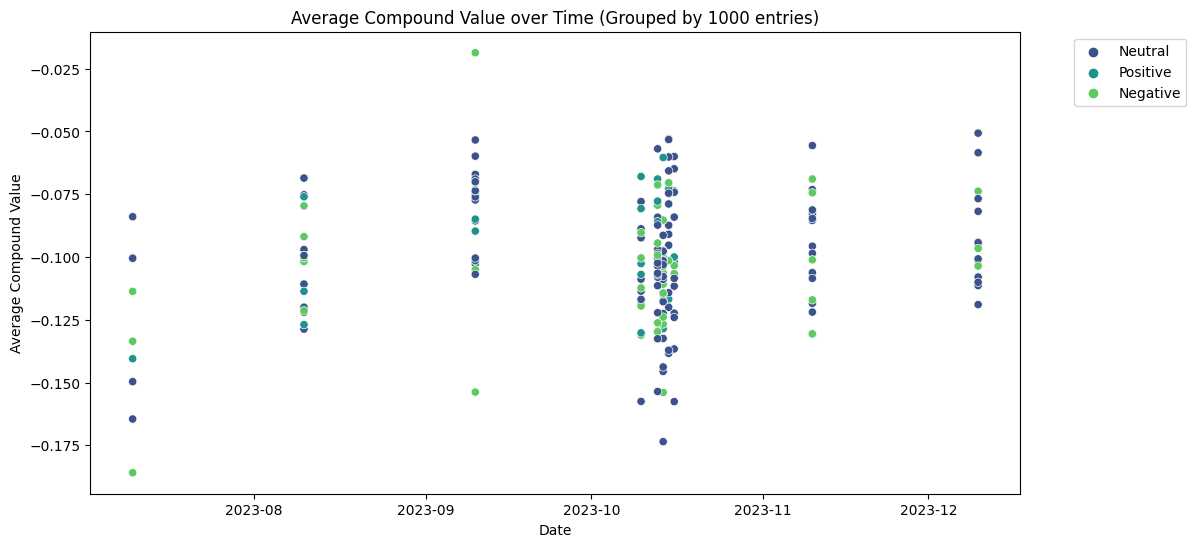

In [ ]:
# Group data by intervals of 1000 entries
df1['group'] = (df1.index // 1000) + 1
grouped_data = df1.groupby(['group', pd.Grouper(key='created_time', freq='D')]).agg({'Compound': 'mean', 'Sentiment': 'first'}).reset_index()

# Plotting with Seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x='created_time', y='Compound', hue='Sentiment', data=grouped_data, palette='viridis', marker='o')

plt.title('Average Compound Value over Time (Grouped by 1000 entries)')
plt.xlabel('Date')
plt.ylabel('Average Compound Value')

# Move the legend outside the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()